In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
all_off_filename = 'all_oof_NN.npy'
all_test_pred_filename = 'all_test_preds_NN.npy'
all_off_filename = 'all_oof_NN_v2.npy'
all_test_pred_filename = 'all_test_preds_NN_v2.npy'
all_test_pred_LGBM_filename = 'all_test_preds.npy'

In [4]:
df_train = pd.read_csv('train_with_counts.csv')
y = df_train['target'].values
indexes = np.load('indexes_shuffled.npy')
all_off_LGBM = np.load('all_oof.npy')
all_oof = np.load(all_off_filename)
y_LGBM = df_train['target'].values[indexes]
test_predictions = np.load(all_test_pred_filename)
test_predictions_LGBM = np.load(all_test_pred_LGBM_filename)

In [5]:
# Por que esta diff con arboles respecto a NN
# NN 0.9177207526081146
# NN_2 0.8913345808747772
print(roc_auc_score(y_LGBM, all_off_LGBM.mean(axis=1)))
print(roc_auc_score(y, all_oof.mean(axis=1)))

0.6765062898725573
0.8913345808747772


In [27]:
unique_values, unique_indexes, unique_inverse, unique_counts  = np.unique(all_oof[0, :], 
                                                                          return_counts=True, return_index=True, return_inverse=True)
errors = np.where(unique_counts[unique_inverse]>1)[0]
print(errors)

[]


In [28]:
N = len(np.where(all_oof[13]!=0)[0])
roc_evol = []
roc_evol_LGBM = []
acc_diff = 0
merged_oof = np.zeros_like(all_oof)
for i in range(N):
    NN_roc = roc_auc_score(y, all_oof[:, i])    
    LGBM_roc = roc_auc_score(y_LGBM, all_off_LGBM[:, i])
    roc_evol.append(roc_auc_score(y, all_oof[:, :i].sum(axis=1)))
    roc_evol_LGBM.append(roc_auc_score(y_LGBM, all_off_LGBM[:, :i].sum(axis=1)))
    diff = NN_roc - LGBM_roc
    acc_diff = acc_diff + diff
#     if i in errors:
#         print(f'var_{i}: {NN_roc:.4f} - {LGBM_roc:.4f} = {diff:.4f} error')
#     else:
    print(f'var_{i}: {NN_roc:.4f} - {LGBM_roc:.4f} = {diff:.4f}')
    if diff>0:
        
        merged_oof[:, i] = all_oof[indexes, i]
    else:
        merged_oof[:, i] = all_off_LGBM[:, i]
acc_diff

var_0: 0.5451 - 0.5479 = -0.0028
var_1: 0.5443 - 0.5453 = -0.0010
var_2: 0.5509 - 0.5508 = 0.0002
var_3: 0.5076 - 0.5072 = 0.0004
var_4: 0.5085 - 0.5060 = 0.0025
var_5: 0.5270 - 0.5208 = 0.0062
var_6: 0.5612 - 0.5388 = 0.0224
var_7: 0.5029 - 0.5020 = 0.0009
var_8: 0.5189 - 0.5161 = 0.0028
var_9: 0.5340 - 0.5358 = -0.0019
var_10: 0.5044 - 0.5021 = 0.0023
var_11: 0.5205 - 0.5149 = 0.0056
var_12: 0.5583 - 0.5504 = 0.0078
var_13: 0.5455 - 0.5522 = -0.0067
var_14: 0.5080 - 0.5032 = 0.0049
var_15: 0.5129 - 0.5049 = 0.0079
var_16: 0.5090 - 0.5042 = 0.0048
var_17: 0.5048 - 0.4982 = 0.0066
var_18: 0.5370 - 0.5394 = -0.0024
var_19: 0.5127 - 0.5035 = 0.0092
var_20: 0.5162 - 0.5199 = -0.0037
var_21: 0.5531 - 0.5565 = -0.0034
var_22: 0.5522 - 0.5462 = 0.0060
var_23: 0.5198 - 0.5200 = -0.0002
var_24: 0.5243 - 0.5259 = -0.0015
var_25: 0.5108 - 0.5061 = 0.0047
var_26: 0.5573 - 0.5569 = 0.0004
var_27: 0.5050 - 0.5010 = 0.0039
var_28: 0.5223 - 0.5156 = 0.0068
var_29: 0.5041 - 0.4977 = 0.0063
var_30: 0.5

0.7347591602760687

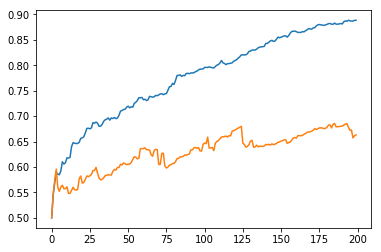

In [29]:
plt.plot(roc_evol)
plt.plot(roc_evol_LGBM)

In [11]:
import statsmodels.api as sm

# For neural network

In [17]:
all_oof_intercept = np.append(np.ones((200000,1)), all_oof, axis=1)
all_oof_intercept.shape

(200000, 201)

In [18]:
N=200
logr_NN = sm.Logit(y, all_oof_intercept[:, :N+1])
%time logr_NN = logr_NN.fit(disp=1, method='newton')
ensemble_preds = logr_NN.predict(all_oof_intercept[:, :N+1])
ensemble_auc = roc_auc_score(y, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()
# Combined Model with magic Val_AUC= 0.91583
# Combined Model with magic Val_AUC= 0.91631
# Combined Model with magic Val_AUC= 0.91792
# Combined Model with magic Val_AUC= 0.9185
# Combined Model with magic Val_AUC= 0.91993
# Combined Model with magic Val_AUC= 0.9199

Optimization terminated successfully.
         Current function value: 0.186613
         Iterations 9
CPU times: user 11.8 s, sys: 868 ms, total: 12.6 s
Wall time: 2.11 s
##################
Combined Model with magic Val_AUC= 0.91441



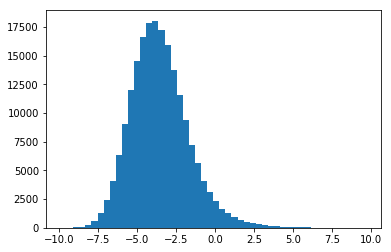

In [33]:
test_predictions_intercept = np.append(np.ones((200000,1)), test_predictions, axis=1)
test_predictions_ensamble = logr_NN.predict(test_predictions_intercept)
_ = plt.hist(np.log(test_predictions_ensamble/(1-test_predictions_ensamble)), 50)

# For LGMB

In [34]:
N_LGBM = N
all_off_LGBM_intercept = np.append(np.ones((200000,1)), all_off_LGBM, axis=1)
print(all_off_LGBM_intercept.shape)
all_off_LGBM_intercept[:, :N_LGBM+1].shape

(200000, 201)


(200000, 201)

In [35]:
logr_LGBM = sm.Logit(y_LGBM, all_off_LGBM_intercept[:, :N_LGBM+1])
%time logr_LGBM = logr_LGBM.fit(disp=1, method='newton')
ensemble_preds = logr_LGBM.predict(all_off_LGBM_intercept[:, :N_LGBM+1])
ensemble_auc = roc_auc_score(y_LGBM, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

Optimization terminated successfully.
         Current function value: 0.180549
         Iterations 9
CPU times: user 11.9 s, sys: 788 ms, total: 12.6 s
Wall time: 2.11 s
##################
Combined Model with magic Val_AUC= 0.92011



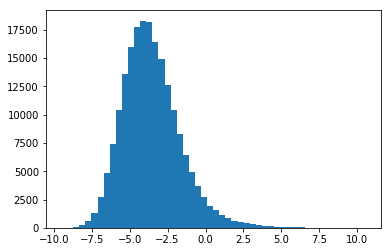

In [36]:
test_predictions_LGBM_intercept = np.append(np.ones((200000,1)), test_predictions_LGBM, axis=1)
LGBM_test_predictions_ensamble = logr_LGBM.predict(test_predictions_LGBM_intercept)
_ = plt.hist(np.log(LGBM_test_predictions_ensamble/(1-LGBM_test_predictions_ensamble)), 50)

# Merged #1 
(No parece muy sensato reemplazar si no más tomar todos como es el caso de Merged #2)

In [37]:
merged_oof_intercept = np.append(np.ones((200000,1)), merged_oof, axis=1)
print(merged_oof_intercept.shape)
merged_oof_intercept[:, :N+1].shape

(200000, 201)


(200000, 201)

In [38]:
logr_M1 = sm.Logit(y_LGBM, merged_oof_intercept[:, :N+1])
%time logr_M1 = logr_M1.fit(disp=1, method='newton')
ensemble_preds = logr_M1.predict(merged_oof_intercept[:, :N+1])
ensemble_auc = roc_auc_score(y_LGBM, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()
# Combined Model with magic Val_AUC= 0.91798
# Combined Model with magic Val_AUC= 0.91839
# Combined Model with magic Val_AUC= 0.91894
# Combined Model with magic Val_AUC= 0.92032

Optimization terminated successfully.
         Current function value: 0.184592
         Iterations 9
CPU times: user 11.7 s, sys: 749 ms, total: 12.5 s
Wall time: 2.08 s
##################
Combined Model with magic Val_AUC= 0.91614



# Merged #2

In [39]:
merged_oof_2 = np.append(all_oof[indexes, :N], all_off_LGBM[:, :N], axis=1)
merged_oof_intercept_2 = np.append(np.ones((200000,1)), merged_oof_2, axis=1)
merged_oof_intercept_2.shape

(200000, 401)

In [40]:
logr_M2 = sm.Logit(y_LGBM, merged_oof_intercept_2)
%time logr_M2 = logr_M2.fit(disp=1, method='newton')
ensemble_preds = logr_M2.predict(merged_oof_intercept_2)
ensemble_auc = roc_auc_score(y_LGBM, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()
# Combined Model with magic Val_AUC= 0.92466
# Combined Model with magic Val_AUC= 0.92468
# Combined Model with magic Val_AUC= 0.92469
# Combined Model with magic Val_AUC= 0.92478
# Combined Model with magic Val_AUC= 0.92479

Optimization terminated successfully.
         Current function value: 0.175708
         Iterations 9
CPU times: user 29.6 s, sys: 1.39 s, total: 31 s
Wall time: 5.18 s
##################
Combined Model with magic Val_AUC= 0.92473



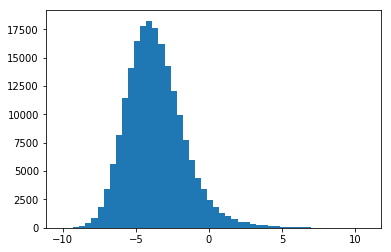

In [41]:
test_merged_predictions = np.append(test_predictions, test_predictions_LGBM, axis=1)
test_merged_predictions_intercept = np.append(np.ones((200000,1)), test_merged_predictions, axis=1)
test_merged_predictions_ensamble = logr_M2.predict(test_merged_predictions_intercept)
_ = plt.hist(np.log(test_merged_predictions_ensamble/(1-test_merged_predictions_ensamble)), 50)

# Submissions

In [48]:
train_path = '../../datasets/santander_customer_transaction_prediction/train.csv'
test_path = '../../datasets/santander_customer_transaction_prediction/test.csv'
def save_submit_file(predictions, filename, message, test_filename=test_path, index_column='ID_code', target_column = 'target'):
    df_test_submit = pd.read_csv(test_filename).set_index(index_column)
    df_test_submit[target_column] = predictions
    df_test_submit[[target_column]].to_csv(filename)
    return "kaggle competitions submit -c santander-customer-transaction-prediction -f {} -m '{}'".format(filename, message)

# Submit LGBM

In [49]:
# 0.91850 0.92022
save_submit_file(LGBM_test_predictions_ensamble, 'submit_LGBM.csv', 'test with magic')

"kaggle competitions submit -c santander-customer-transaction-prediction -f submit_LGBM.csv -m 'test with magic'"

In [50]:
# ! kaggle competitions submit -c santander-customer-transaction-prediction -f submit_LGBM.csv -m 'test with magic'

100%|███████████████████████████████████████| 6.09M/6.09M [00:09<00:00, 709kB/s]
Successfully submitted to Santander Customer Transaction Prediction

# Submit NN

In [55]:
# 0.91784 0.91753
save_submit_file(test_predictions_ensamble, 'submit_NN.csv', 'test magic NN')

"kaggle competitions submit -c santander-customer-transaction-prediction -f submit_NN.csv -m 'test magic NN'"

In [1]:
# ! kaggle competitions submit -c santander-customer-transaction-prediction -f submit_NN.csv -m 'test magic NN'

100%|███████████████████████████████████████| 6.16M/6.16M [00:07<00:00, 850kB/s]
Successfully submitted to Santander Customer Transaction Prediction

# Submit Merge #2

In [51]:
# 0.92073 0.92125
save_submit_file(test_merged_predictions_ensamble, 'submit_LGBM_NN.csv', 'test with magic and NN')

"kaggle competitions submit -c santander-customer-transaction-prediction -f submit_LGBM_NN.csv -m 'test with magic and NN'"

In [52]:
# ! kaggle competitions submit -c santander-customer-transaction-prediction -f submit_LGBM_NN.csv -m 'test with magic and NN'

100%|███████████████████████████████████████| 6.11M/6.11M [00:15<00:00, 423kB/s]
Successfully submitted to Santander Customer Transaction Prediction